In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np 
import hvplot.pandas 

# Load dataframe and reassess 

In [2]:
#Read csv into pandas Dataframe
coffee_original_df = pd.read_csv("Resources/NEW_coffee_final.csv")

In [3]:
# Check database has been loaded 
coffee_original_df.head()

,slug,name,roaster,roast,country_of_origin,desc_1,desc_2,rating,aroma,acid,...,region_hawaii,region_asia_pacific,region_south_america,type_espresso,type_organic,type_fair_trade,type_decaffeinated,type_pod_capsule,type_blend,type_estate
0,/review/ethiopia-deri-kochoha-2,ethiopia deri kochoha,flight coffee co,medium_light,ethiopia,"bright, crisp, sweetly tart citrus medley, cac...",from the deri kochoha mill in the hagere marya...,93,9.0,8.0,...,0,0,0,0,0,0,0,0,0,0
1,/review/espresso-14,espresso,doi chaang coffee,medium,thailand,"evaluated as espresso deeply rich, sweetly roa...",doi chaang is a singleestate coffee produced b...,91,8.0,NaN,...,0,1,0,1,0,0,0,0,0,1
2,/review/kenya-ruthaka-peaberry,kenya ruthaka peaberry,temple coffee and tea,medium,kenya,"deeply sweet, richly savory dark chocolate, pi...",despite challenges ranging from contested gove...,95,9.0,8.0,...,0,0,0,0,0,0,0,0,0,0
3,/review/ethiopia-gora-kone-sidamo,ethiopia gora kone sidamo,temple coffee and tea,medium_light,ethiopia,"fruitforward, richly chocolaty raspberry couli...",southern ethiopia coffees like this one are la...,93,9.0,8.0,...,0,0,0,0,0,0,0,0,0,0
4,/review/specialty-coffee-blend-espresso,specialty coffee blend espresso,choosy gourmet,medium_light,kenya,"evaluated as espresso rich, chocolaty, sweetly...",a blend of coffees from ethiopia naturalproces...,93,9.0,NaN,...,0,0,0,1,0,0,0,0,0,0


In [4]:
coffee_original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4509 entries, 0 to 4508
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   slug                    4509 non-null   object 
 1   name                    4509 non-null   object 
 2   roaster                 4509 non-null   object 
 3   roast                   4399 non-null   object 
 4   country_of_origin       4509 non-null   object 
 5   desc_1                  4509 non-null   object 
 6   desc_2                  4509 non-null   object 
 7   rating                  4509 non-null   int64  
 8   aroma                   4475 non-null   float64
 9   acid                    3685 non-null   float64
 10  body                    4499 non-null   float64
 11  flavor                  4496 non-null   float64
 12  aftertaste              4091 non-null   float64
 13  region_africa_arabia    4509 non-null   int64  
 14  region_caribbean        4509 non-null   

## Remove null values for modelling and training 

In [5]:
# Create features and target
coffee_test = coffee_original_df[['aroma','body','flavor','acid','aftertaste', 'rating']]
coffee_test = coffee_test.dropna()

In [6]:
# import matplotlib.pyplot as plt

# # Assuming scaled_data has shape (n_samples, n_features)
# n_features = scaled_data.shape[1]

# # Create a 2x2 grid for subplots
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# # Flatten the 2D array of subplots for easier indexing
# axes = axes.flatten()

# # Create histograms for the first four features
# for i in range(min(4, n_features)):
#     axes[i].hist(scaled_data[:, i], bins=50, color='blue', alpha=0.7)
#     axes[i].set_title(f'Standardized Feature {i+1} Distribution')
#     axes[i].set_xlabel(f'Standardized Feature {i+1}')
#     axes[i].set_ylabel('Frequency')

# # Adjust layout to prevent overlapping
# plt.tight_layout()
# plt.show()


This shows us that generally there are not too many outliers and standardisation is good. 

In [7]:
# print("Shape of scaled_data:", scaled_data.shape)
# print("Shape of y:", y.shape)
# print("NaN or missing values in scaled_data:", np.isnan(scaled_data).any())
# print("Missing values in y:", y.isnull().any().any())

## Encode target and include one-hot encoding into dataframe 

In [8]:
# labelEncode the slug and create a feature array 
from sklearn.preprocessing import LabelEncoder 

# Label encode the 'slug' column and create a new column 'target'
label_encoder = LabelEncoder()
coffee_test['target'] = label_encoder.fit_transform(coffee_test['rating'])

# Drop the original 'slug' column
coffee_test.drop('rating', axis=1, inplace=True)
coffee_test.head()

,aroma,body,flavor,acid,aftertaste,target
0,9.0,9.0,9.0,8.0,8.0,27
2,9.0,9.0,10.0,8.0,8.0,29
3,9.0,9.0,9.0,8.0,8.0,27
5,9.0,9.0,9.0,8.0,8.0,28
6,9.0,9.0,9.0,8.0,8.0,28


In [9]:
# Assuming X is your DataFrame with columns 'aroma', 'body', 'flavor', 'acid', and 'aftertaste'
categorical_columns = ['aroma', 'body', 'flavor', 'acid', 'aftertaste']

# Use get_dummies to one-hot encode the categorical columns
coffee_test_encoded = pd.get_dummies(coffee_test[categorical_columns], columns=categorical_columns, dtype=int)

In [10]:
# Concatenate the one-hot encoded columns to the original DataFrame
coffee_test = pd.concat([coffee_test, coffee_test_encoded], axis=1)

In [11]:
coffee_test.head()

,aroma,body,flavor,acid,aftertaste,target,aroma_2.0,aroma_3.0,aroma_4.0,aroma_5.0,...,acid_10.0,aftertaste_2.0,aftertaste_3.0,aftertaste_4.0,aftertaste_5.0,aftertaste_6.0,aftertaste_7.0,aftertaste_8.0,aftertaste_9.0,aftertaste_10.0
0,9.0,9.0,9.0,8.0,8.0,27,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,9.0,9.0,10.0,8.0,8.0,29,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,9.0,9.0,9.0,8.0,8.0,27,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,9.0,9.0,9.0,8.0,8.0,28,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,9.0,9.0,9.0,8.0,8.0,28,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
# Make the target column the first column for ease access 
target_column = coffee_test['target']

# Drop the 'target' column from the DataFrame
coffee_test.drop('target', axis=1, inplace=True)

# Insert the 'target' column as the first column
coffee_test.insert(0, 'target', target_column)


In [13]:
# Display the Dataframe 
coffee_test.head()

,target,aroma,body,flavor,acid,aftertaste,aroma_2.0,aroma_3.0,aroma_4.0,aroma_5.0,...,acid_10.0,aftertaste_2.0,aftertaste_3.0,aftertaste_4.0,aftertaste_5.0,aftertaste_6.0,aftertaste_7.0,aftertaste_8.0,aftertaste_9.0,aftertaste_10.0
0,27,9.0,9.0,9.0,8.0,8.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,29,9.0,9.0,10.0,8.0,8.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,27,9.0,9.0,9.0,8.0,8.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,28,9.0,9.0,9.0,8.0,8.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,28,9.0,9.0,9.0,8.0,8.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [14]:
# Create a feature from the 2nd to last column - include all -one-hot encoded columns 
# Assuming the 'target' column is the first column, and you want features from the 2nd to the end
X = coffee_test.iloc[:, 1:]
X

,aroma,body,flavor,acid,aftertaste,aroma_2.0,aroma_3.0,aroma_4.0,aroma_5.0,aroma_6.0,...,acid_10.0,aftertaste_2.0,aftertaste_3.0,aftertaste_4.0,aftertaste_5.0,aftertaste_6.0,aftertaste_7.0,aftertaste_8.0,aftertaste_9.0,aftertaste_10.0
0,9.0,9.0,9.0,8.0,8.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,9.0,9.0,10.0,8.0,8.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,9.0,9.0,9.0,8.0,8.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,9.0,9.0,9.0,8.0,8.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,9.0,9.0,9.0,8.0,8.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4102,8.0,8.0,8.0,8.0,8.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4103,8.0,8.0,8.0,8.0,8.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4104,7.0,7.0,6.0,7.0,7.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4105,7.0,7.0,7.0,7.0,7.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Assess for PCA segementation and difference of accuracy score 

In [15]:
# Import the PCA module
from sklearn.decomposition import PCA

In [16]:
# Instantiate the PCA instance and declare the number of PCA variables
pca = PCA(n_components=5)

In [17]:
# Fit the PCA model on the transformed credit card DataFrame
coffee_test_pca = pca.fit_transform(coffee_test)

# Review the first 5 rows of list data
coffee_test_pca[:5]

array([[-1.9484309 , -1.08888578, -0.12195625,  0.87308352,  0.14756407],
       [-3.89356944, -1.12837937,  0.00851528,  0.37441005, -0.54317961],
       [-1.9484309 , -1.08888578, -0.12195625,  0.87308352,  0.14756407],
       [-2.84798998, -1.13743064, -0.08579518,  0.74629172, -0.05677022],
       [-2.84798998, -1.13743064, -0.08579518,  0.74629172, -0.05677022]])

In [18]:
# Calculate the PCA explained variance ratio
pca.explained_variance_ratio_

array([0.7606159 , 0.05374648, 0.04555577, 0.03270945, 0.02979123])

In [19]:
# Create the PCA DataFrame
coffee_pca_df = pd.DataFrame(
    coffee_test_pca,
    columns=["PCA1", "PCA2", "PCA3", "PCA4", "PCA5"]
)

# Review the PCA DataFrame
coffee_pca_df.head()

,PCA1,PCA2,PCA3,PCA4,PCA5
0,-1.948431,-1.088886,-0.121956,0.873084,0.147564
1,-3.893569,-1.128379,0.008515,0.374410,-0.543180
2,-1.948431,-1.088886,-0.121956,0.873084,0.147564
3,-2.847990,-1.137431,-0.085795,0.746292,-0.056770
4,-2.847990,-1.137431,-0.085795,0.746292,-0.056770


In [47]:
from sklearn.cluster import KMeans 
# Create a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, n_init=10, random_state=1)  # Explicitly set n_init
    k_model.fit(coffee_pca_df)
    inertia.append(k_model.inertia_)

# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

,k,inertia
0,1,45768.038026
1,2,24680.878295
2,3,16916.769198
3,4,12765.624474
4,5,9827.137596


In [48]:
# Plot the Elbow Curve
df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k
)

C:\Users\jesss\anaconda3\envs\PythonData\Lib\site-packages\holoviews\core\data\pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
C:\Users\jesss\anaconda3\envs\PythonData\Lib\site-packages\holoviews\core\data\pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Curve   [k]   (inertia)

In [54]:
# Define the model with 3 clusters
model = KMeans(n_clusters=3, random_state=0, n_init =10)

# Fit the model
model.fit(coffee_pca_df)

# Make predictions
k_3 = model.predict(coffee_pca_df)

# Create a copy of the PCA DataFrame
coffee_info_pca_predictions_df = coffee_pca_df.copy()

# Add a class column with the labels
coffee_info_pca_predictions_df["coffee_segments"] = k_3

In [52]:
# Plot the clusters
coffee_info_pca_predictions_df.hvplot.scatter(
    x="PCA1",
    y="PCA2",
    by="coffee_segments",
    width=800,
    height=500
)


C:\Users\jesss\anaconda3\envs\PythonData\Lib\site-packages\holoviews\core\data\pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
C:\Users\jesss\anaconda3\envs\PythonData\Lib\site-packages\holoviews\core\data\pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:NdOverlay   [coffee_segments]
   :Scatter   [PCA1]   (PCA2)

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(coffee_test, coffee_test))

[[1.         0.99857452 1.         ... 0.98506735 0.98818361 0.98953584]
 [0.99857452 1.         0.99857452 ... 0.98101213 0.9854008  0.98792363]
 [1.         0.99857452 1.         ... 0.98506735 0.98818361 0.98953584]
 ...
 [0.98506735 0.98101213 0.98506735 ... 1.         0.9973136  0.99507558]
 [0.98818361 0.9854008  0.98818361 ... 0.9973136  1.         0.99760375]
 [0.98953584 0.98792363 0.98953584 ... 0.99507558 0.99760375 1.        ]]


Interpretation:

Cosine similarity ranges from -1 to 1, where 1 indicates identical vectors, 0 indicates orthogonal (uncorrelated) vectors, and -1 indicates diametrically opposed vectors. In your case, values close to 1 suggest similarity between samples.

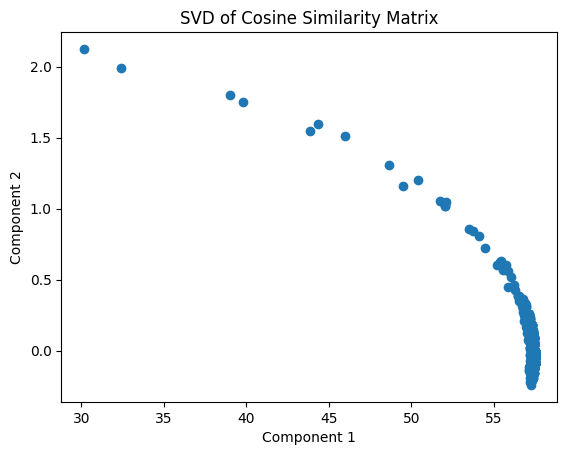

In [25]:
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming similarity_matrix is your cosine similarity matrix
similarity_matrix = cosine_similarity(coffee_test, coffee_test)

# Applying SVD
svd = TruncatedSVD(n_components=2)
svd_result = svd.fit_transform(similarity_matrix)

# Visualizing the results
plt.scatter(svd_result[:, 0], svd_result[:, 1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('SVD of Cosine Similarity Matrix')
plt.show()


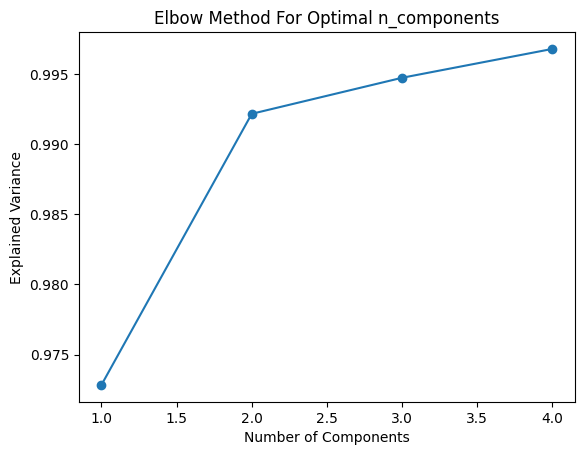

In [26]:
import numpy as np

# Assume similarity_matrix is your cosine similarity matrix
similarity_matrix = cosine_similarity(coffee_test, coffee_test)

# Apply TruncatedSVD for different n_components
n_components_range = range(1, 5)  # Adjust the range based on your needs
explained_variances = []

for n_components in n_components_range:
    svd = TruncatedSVD(n_components=n_components)
    svd.fit(similarity_matrix)
    explained_variances.append(np.sum(svd.explained_variance_ratio_))

# Plot the elbow curve
plt.plot(n_components_range, explained_variances, marker='o')
plt.title('Elbow Method For Optimal n_components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()


indicate that the explained variance doesn't change much with the number of components. In such cases, choosing the number of components can be more subjective.

In [27]:
# Increase limit on jupyter for display and run 
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [28]:
from itertools import combinations

# Assuming you have a DataFrame named 'coffee_data' with columns like 'aroma', 'flavor', 'acid', 'body', 'aftertaste'
selected_components = ['aroma', 'flavor', 'acid', 'body', 'aftertaste']

# Generate all possible pairs of different components
component_sets = list(combinations(selected_components, 5))

# Initialize an empty array to store individual component similarity matrices
similarity_matrices_components = {}

# Calculate cosine similarity for each selected component set 
for component_set in component_sets:
    # Select only the specified components
    selected_features = coffee_test[list(component_set)]
    
    # Calculate cosine similarity based on the selected components
    similarity_matrix_component = cosine_similarity(selected_features, selected_features)
    
    # Store the similarity matrix with the component pair as the key
    similarity_matrices_components[component_set] = similarity_matrix_component

# Set your chosen similarity threshold
threshold = 0.95  # Adjust this value based on your observations

# Identify pairs with similarity above the threshold
similar_pairs_components = []

for component_set, similarity_matrix_component in similarity_matrices_components.items():
    # Ensure the similarity matrix is not empty
    if similarity_matrix_component.size > 0:
        similar_pairs_component = np.argwhere(similarity_matrix_component > threshold)
        similar_pairs_components.extend([(component_set, i, j) for i, j in similar_pairs_component])

# Get the similarity values for the identified pairs
similarities_components = [similarity_matrices_components[component_set][i, j] for component_set, i, j in similar_pairs_components]

# Get the indices of the top 5 similar pairs based on descending similarity
top_5_indices_components = np.argsort(similarities_components)[::-1][:5]

# Extract and print the top 5 similar pairs and their similarities
print("Top 5 Similar Pairs Based on Different Components:")

for index in top_5_indices_components:
    component_set, i, j = similar_pairs_components[index]
    similarity_component = similarities_components[index]
    print(f"Pair {i} and {j} with components {component_set} have similarity {similarity_component}")

Top 5 Similar Pairs Based on Different Components:
Pair 1550 and 936 with components ('aroma', 'flavor', 'acid', 'body', 'aftertaste') have similarity 1.0000000000000004
Pair 2077 and 1062 with components ('aroma', 'flavor', 'acid', 'body', 'aftertaste') have similarity 1.0000000000000004
Pair 1176 and 2093 with components ('aroma', 'flavor', 'acid', 'body', 'aftertaste') have similarity 1.0000000000000004
Pair 1176 and 2096 with components ('aroma', 'flavor', 'acid', 'body', 'aftertaste') have similarity 1.0000000000000004
Pair 1176 and 2139 with components ('aroma', 'flavor', 'acid', 'body', 'aftertaste') have similarity 1.0000000000000004


In [29]:
# Define target vector
y = coffee_test['target'].values.ravel()
y

array([27, 29, 27, ..., 17, 18, 19], dtype=int64)

In [30]:
# Splitting into Train and Test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

In [31]:
# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [32]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [33]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

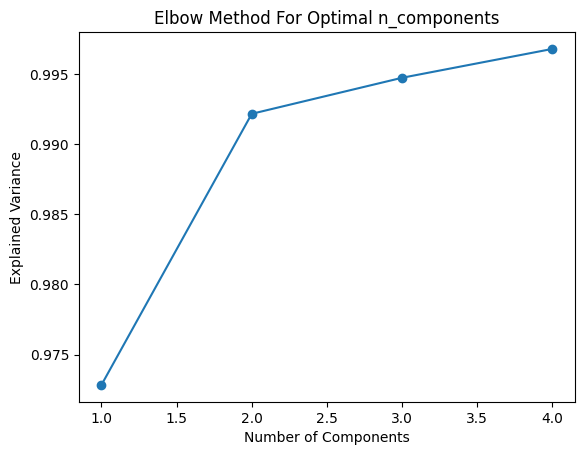

In [34]:
import numpy as np

# Assume similarity_matrix is your cosine similarity matrix
similarity_matrix = cosine_similarity(coffee_test, coffee_test)

# Apply TruncatedSVD for different n_components
n_components_range = range(1, 5)  # Adjust the range based on your needs
explained_variances = []

for n_components in n_components_range:
    svd = TruncatedSVD(n_components=n_components)
    svd.fit(similarity_matrix)
    explained_variances.append(np.sum(svd.explained_variance_ratio_))

# Plot the elbow curve
plt.plot(n_components_range, explained_variances, marker='o')
plt.title('Elbow Method For Optimal n_components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the logistic regression model
log_classifier = LogisticRegression(solver='lbfgs', max_iter=4000)

# Train the model
log_classifier.fit(X_train_scaled, y_train)

# Assess the accuracy from the logistic regression model 
y_pred = log_classifier.predict(X_test_scaled)
print(f"Logistic regression model accuracy: {accuracy_score(y_test, y_pred):.3f}")

Logistic regression model accuracy: 0.504


In [36]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  1  2  2  1  1  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  

In [37]:
# Check shape of all data
print("Shape of X:", X_train.shape)
print("Shape of y:", y_train.shape)
print("Missing values in X_train_scaled:", np.isnan(X_train_scaled).any().any())
print("Missing values in y:", np.isnan(y).any())

Shape of X: (2665, 48)
Shape of y: (2665,)
Missing values in X_train_scaled: False
Missing values in y: False


In [38]:
# Calculate the cosine similarity matrix for the entire dataset
similarity_matrix = cosine_similarity(X)

# Calculate the index of the most similar item for each item
predictions = similarity_matrix.argmax(axis=1)


In [39]:
# Create a ground truth column for interactions (1 for interaction, 0 for no interaction)
X['interactions'] = np.random.choice([0, 1], size=len(X), p=[0.8, 0.2])

# Print the DataFrame to see the changes
print(X)


      aroma  body  flavor  acid  aftertaste  aroma_2.0  aroma_3.0  aroma_4.0  \
0       9.0   9.0     9.0   8.0         8.0          0          0          0   
2       9.0   9.0    10.0   8.0         8.0          0          0          0   
3       9.0   9.0     9.0   8.0         8.0          0          0          0   
5       9.0   9.0     9.0   8.0         8.0          0          0          0   
6       9.0   9.0     9.0   8.0         8.0          0          0          0   
...     ...   ...     ...   ...         ...        ...        ...        ...   
4102    8.0   8.0     8.0   8.0         8.0          0          0          0   
4103    8.0   8.0     8.0   8.0         8.0          0          0          0   
4104    7.0   7.0     6.0   7.0         7.0          0          0          0   
4105    7.0   7.0     7.0   7.0         7.0          0          0          0   
4106    7.0   7.0     8.0   7.0         7.0          0          0          0   

      aroma_5.0  aroma_6.0  ...  aftert

In [40]:
print("Shape of similarity_matrix:", similarity_matrix.shape)
print("Shape of predictions:", predictions.shape)
print(X['interactions'].shape)

Shape of similarity_matrix: (3332, 3332)
Shape of predictions: (3332,)
(3332,)


In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Adjust 'average' parameter as needed
recall = recall_score(y_test, y_pred, average='weighted')  # Adjust 'average' parameter as needed
f1 = f1_score(y_test, y_pred, average='weighted')  # Adjust 'average' parameter as needed

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")


Accuracy: 0.504
Precision: 0.508
Recall: 0.504
F1 Score: 0.490


C:\Users\jesss\anaconda3\envs\PythonData\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jesss\anaconda3\envs\PythonData\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
# Assume 'N' is the number of top recommendations you want
# Assuming X is a DataFrame
recommended_items = X.iloc[predictions]

N = 5

# Get the top N recommendations for each test item
top_n_recommendations = np.argsort(-similarity_matrix, axis=0)[:N, :]
top_n_recommendations

array([[   0,  427,    0, ..., 3329, 2446, 3331],
       [ 334,  399,  334, ..., 2182, 3236, 3155],
       [ 333, 1276,  333, ..., 3238, 3050, 2609],
       [ 591,  582,  591, ..., 1995, 3232, 3296],
       [ 592, 2107,  592, ..., 3050, 1652, 1595]], dtype=int64)

In [43]:
threshold = 0.7
binary_predictions = (similarity_matrix > threshold).astype(int)

In [44]:
def calculate_precision(predictions, labels):
    true_positives = np.sum((predictions == 1) & (labels == 1))
    false_positives = np.sum((predictions == 1) & (labels == 0))

    # Avoid division by zero
    if (true_positives + false_positives) == 0:
        precision = 0
    else:
        precision = true_positives / (true_positives + false_positives)

    return precision


In [45]:
labels = X['interactions'].values

In [46]:
precision = calculate_precision(predictions, labels)
print(f"Precision: {precision}")

Precision: 0.2222222222222222
